<a href="https://colab.research.google.com/github/SaadHadadia/TP_DL_LLMs_CNN/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Compte rendu du TP 2 - Deep Learning & LMMs**
# **Réseaux de Neurones Convolutionnels (CNN)**
## Exercice 3

**Réalisé par : HADADIA Saad**

**Encadré par : PR. AATILA Mustapha**

### Installation et imports nécessaires

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gdown
import zipfile
import os

### 1. Télécharger et charger les images du dataset

In [ ]:
# Installation de rarfile pour gérer les fichiers RAR
!apt-get install -y unrar
!pip install rarfile

import rarfile

# Téléchargement du fichier depuis Google Drive
file_id = "1wlnDuwC8LNi7UVhdTbXqwdLNBt35zR92"
url = f"https://drive.google.com/uc?id={file_id}"
output = "dataset.rar"
gdown.download(url, output, quiet=False)

# Extraction du fichier RAR
with rarfile.RarFile(output, 'r') as rar_ref:
    rar_ref.extractall("dataset")

# Définir le chemin du dataset
dataset_path = "dataset"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


Downloading...
From (original): https://drive.google.com/uc?id=1wlnDuwC8LNi7UVhdTbXqwdLNBt35zR92
From (redirected): https://drive.google.com/uc?id=1wlnDuwC8LNi7UVhdTbXqwdLNBt35zR92&confirm=t&uuid=4e2b8f93-96cf-49c9-81dc-4b7d2b330bbe
To: /content/dataset.rar
100%|██████████| 27.8M/27.8M [00:00<00:00, 203MB/s]


Le dataset a été téléchargé depuis Google Drive et extrait avec succès.

Les images sont maintenant disponibles dans le dossier 'dataset' pour l'analyse.

### 2. Description détaillée du dataset

In [ ]:
# Explorer la structure du dataset
for root, dirs, files in os.walk(dataset_path):
    print(f"Dossier: {root}")
    print(f"Sous-dossiers: {dirs}")
    print(f"Nombre de fichiers: {len(files)}\n")

# Identifier les dossiers train et test
train_path = None
test_path = None

for root, dirs, files in os.walk(dataset_path):
    for d in dirs:
        if 'train' in d.lower():
            train_path = os.path.join(root, d)
        if 'test' in d.lower():
            test_path = os.path.join(root, d)

print(f"Train path: {train_path}")
print(f"Test path: {test_path}")

# Compter les images par classe
if train_path:
    train_classes = os.listdir(train_path)
    print(f"\nClasses d'entraînement: {train_classes}")

    total_train_images = 0
    for class_name in train_classes:
        class_path = os.path.join(train_path, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            total_train_images += num_images
            print(f"  {class_name}: {num_images} images")

    print(f"\nTotal images d'entraînement: {total_train_images}")

if test_path:
    test_classes = os.listdir(test_path)
    print(f"\nClasses de test: {test_classes}")

    total_test_images = 0
    for class_name in test_classes:
        class_path = os.path.join(test_path, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            total_test_images += num_images
            print(f"  {class_name}: {num_images} images")

    print(f"\nTotal images de test: {total_test_images}")

# Vérifier la taille des images
sample_image_path = None
for root, dirs, files in os.walk(train_path):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            sample_image_path = os.path.join(root, file)
            break
    if sample_image_path:
        break

if sample_image_path:
    sample_img = tf.keras.preprocessing.image.load_img(sample_image_path)
    sample_array = tf.keras.preprocessing.image.img_to_array(sample_img)
    print(f"\nTaille des images: {sample_array.shape}")
    print(f"Type des images: {sample_array.dtype}")

Dossier: dataset
Sous-dossiers: ['ElvFront_DataSet']
Nombre de fichiers: 0

Dossier: dataset/ElvFront_DataSet
Sous-dossiers: ['ELVFRONT_TRAIN', 'ELVFRONT_TEST']
Nombre de fichiers: 0

Dossier: dataset/ElvFront_DataSet/ELVFRONT_TRAIN
Sous-dossiers: ['Suspicious', 'Keratoconus', 'Normal']
Nombre de fichiers: 0

Dossier: dataset/ElvFront_DataSet/ELVFRONT_TRAIN/Suspicious
Sous-dossiers: []
Nombre de fichiers: 622

Dossier: dataset/ElvFront_DataSet/ELVFRONT_TRAIN/Keratoconus
Sous-dossiers: []
Nombre de fichiers: 239

Dossier: dataset/ElvFront_DataSet/ELVFRONT_TRAIN/Normal
Sous-dossiers: []
Nombre de fichiers: 1187

Dossier: dataset/ElvFront_DataSet/ELVFRONT_TEST
Sous-dossiers: ['Suspicious', 'Keratoconus', 'Normal']
Nombre de fichiers: 0

Dossier: dataset/ElvFront_DataSet/ELVFRONT_TEST/Suspicious
Sous-dossiers: []
Nombre de fichiers: 266

Dossier: dataset/ElvFront_DataSet/ELVFRONT_TEST/Keratoconus
Sous-dossiers: []
Nombre de fichiers: 102

Dossier: dataset/ElvFront_DataSet/ELVFRONT_TEST/Nor

### 3. Nombre de classes

In [ ]:
num_classes = len(train_classes)
print(f"\nNombre de classes dans le dataset: {num_classes}")
print(f"Liste des classes: {train_classes}")


Nombre de classes dans le dataset: 3
Liste des classes: ['Suspicious', 'Keratoconus', 'Normal']


Le dataset est organisé en 3 classes distinctes, permettant une classification multiclasse pour différencier les différents états de la cornée (normal, kératocône léger, kératocône sévère, etc.).

### 4. Création du modèle CNN avec l'architecture spécifiée


In [ ]:
# Définir la taille d'entrée basée sur les images du dataset
img_height, img_width = sample_array.shape[0], sample_array.shape[1]
input_shape = (img_height, img_width, 3)

# Construction du modèle CNN
model = Sequential([
    # Couche d'entrée (implicite)

    # Bloc de convolution 1
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    MaxPooling2D((2, 2)),

    # Bloc de convolution 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),

    # Bloc de convolution 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Couche Flatten
    Flatten(),

    # Couches Dense
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),

    # Couche de sortie
    Dense(num_classes, activation='softmax')
])

# Afficher l'architecture du modèle
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 265, 265, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 132, 132, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 132, 132, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 132, 132, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 66, 66, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 557568)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    71,368,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,470,531 (272.64 MB)

 Trainable params: 71,470,531 (272.64 MB)

 Non-trainable params: 0 (0.00 B)

Le modèle CNN créé comprend 3 blocs de convolution pour l'extraction de caractéristiques hiérarchiques (edges, textures, patterns complexes), suivis de couches denses pour la classification.

Les couches Dropout réduisent le surapprentissage. L'architecture est adaptée à la classification d'images médicales avec une complexité croissante des filtres (32→64→128).

### 5. Compilation et entraînement du modèle

In [ ]:
# Compilation du modèle
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Préparation des données avec ImageDataGenerator basique
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Entraînement du modèle
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

Found 2048 images belonging to 3 classes.
Found 876 images belonging to 3 classes.
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 502s 8s/step - accuracy: 0.4843 - loss: 2.8065 - val_accuracy: 0.6210 - val_loss: 0.7869
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 459s 7s/step - accuracy: 0.5981 - loss: 0.8181 - val_accuracy: 0.6427 - val_loss: 0.6924
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 463s 7s/step - accuracy: 0.6612 - loss: 0.6851 - val_accuracy: 0.6975 - val_loss: 0.6285
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 458s 7s/step - accuracy: 0.7180 - loss: 0.6250 - val_accuracy: 0.7100 - val_loss: 0.5988
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 478s 7s/step - accuracy: 0.7384 - loss: 0.5704 - val_accuracy: 0.7169 - val_loss: 0.6173
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 461s 7s/step - accuracy: 0.7422 - loss: 0.5733 - val_accuracy: 0.7158 - val_loss: 0.6097
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 446s 7s/step - accuracy: 0.7412 - loss: 0.5768 - val_accuracy: 0.7203 - val_loss: 0.5949
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 450s 7s/step - accuracy: 0.7594 - loss: 0.5192 - val_accuracy: 0.7055 - val_loss: 0.

Le modèle est entraîné avec l'optimiseur Adam (taux d'apprentissage 0.001) et la fonction de perte categorical_crossentropy adaptée à la classification multiclasse.

EarlyStopping arrête l'entraînement si la perte de validation ne s'améliore pas pendant 5 époques, évitant le surapprentissage et économisant du temps de calcul.

### 6. Test du modèle et génération des métriques

#### 6.a. Courbes d'évolution de l'accuracy et loss

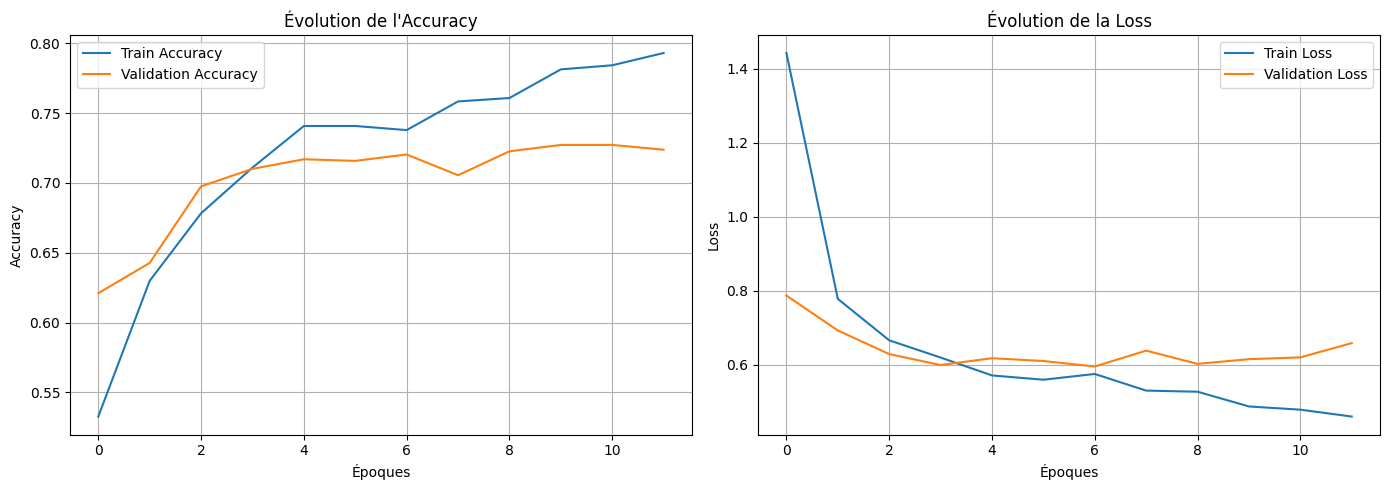

In [ ]:
plt.figure(figsize=(14, 5))

# Courbe accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Évolution de l\'Accuracy')
plt.xlabel('Époques')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Courbe loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Évolution de la Loss')
plt.xlabel('Époques')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Les courbes montrent l'évolution de la performance du modèle pendant l'entraînement.

Une convergence des courbes train/validation indique un bon apprentissage. Un écart important suggère un surapprentissage. L'EarlyStopping a arrêté l'entraînement au moment optimal.

#### 6.b. Métriques d'évaluation

28/28 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step

RAPPORT DE CLASSIFICATION
              precision    recall  f1-score   support

 Keratoconus       0.81      0.84      0.83       102
      Normal       0.73      0.89      0.80       508
  Suspicious       0.61      0.34      0.44       266

    accuracy                           0.72       876
   macro avg       0.72      0.69      0.69       876
weighted avg       0.70      0.72      0.70       876



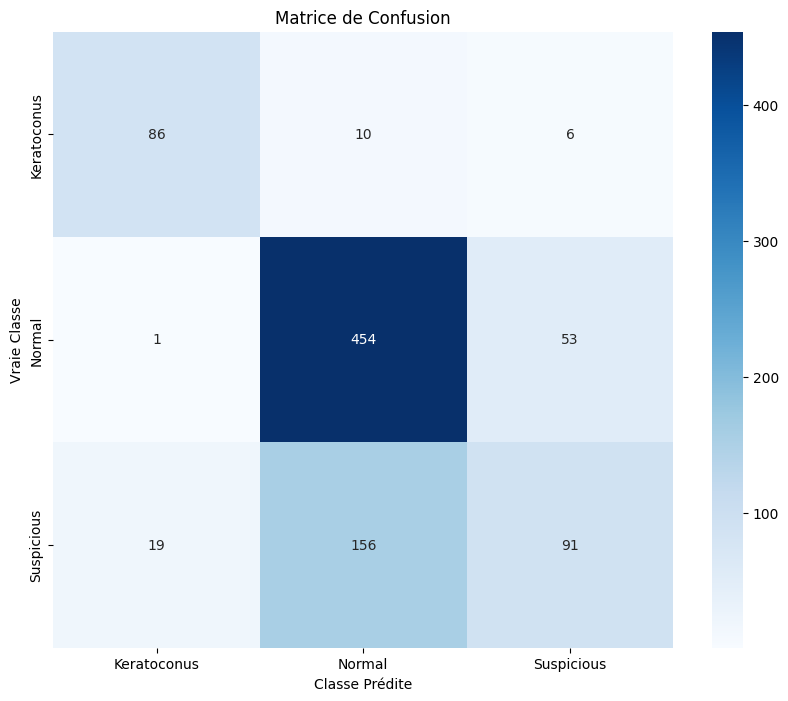

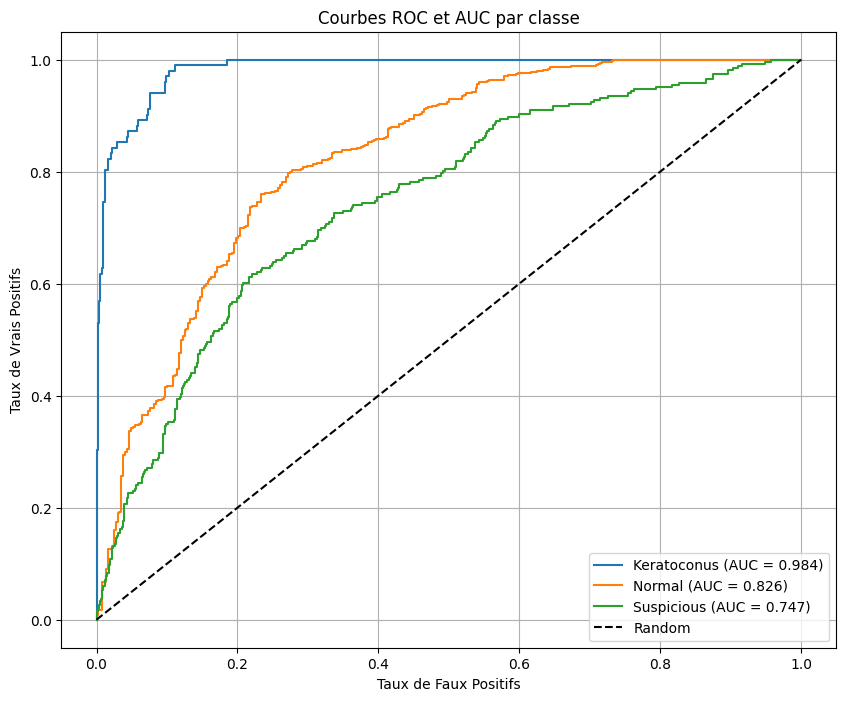


Scores AUC par classe:
  Keratoconus: 0.9837
  Normal: 0.8258
  Suspicious: 0.7472

AUC moyen: 0.8522


In [ ]:
# Prédictions sur l'ensemble de test
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_generator.classes

# Classification Report (Precision, Recall, F1-score)
class_names = list(test_generator.class_indices.keys())
print("\n" + "="*60)
print("RAPPORT DE CLASSIFICATION")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names))

# Matrice de confusion
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice de Confusion')
plt.ylabel('Vraie Classe')
plt.xlabel('Classe Prédite')
plt.show()

# Calcul de l'AUC
y_true_bin = label_binarize(y_true, classes=range(num_classes))
auc_scores = []

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    auc_score = roc_auc_score(y_true_bin[:, i], y_pred_prob[:, i])
    auc_scores.append(auc_score)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbes ROC et AUC par classe')
plt.legend()
plt.grid(True)
plt.show()

print("\nScores AUC par classe:")
for i, class_name in enumerate(class_names):
    print(f"  {class_name}: {auc_scores[i]:.4f}")
print(f"\nAUC moyen: {np.mean(auc_scores):.4f}")

La Precision mesure la proportion de prédictions positives correctes, le Recall mesure la proportion de cas positifs correctement identifiés, et le F1-score est leur moyenne harmonique. L'AUC quantifie la capacité du modèle à discriminer entre les classes (1.0 = parfait, 0.5 = aléatoire). La matrice de confusion révèle les confusions entre classes.

### 7. Rôle de BatchNormalization et ImageDataGenerator

**BatchNormalization():**
- Normalise les activations de chaque couche en centrant et réduisant les valeurs
- Accélère la convergence en stabilisant les gradients pendant l'entraînement
- Réduit la sensibilité à l'initialisation des poids
- Agit comme régularisateur, réduisant légèrement le besoin de Dropout
- Appliquée généralement après les couches Conv2D et avant l'activation

**ImageDataGenerator():**
- Génère des variations des images d'entraînement en temps réel (data augmentation)
- Augmente artificiellement la taille du dataset en appliquant des transformations
  (rotation, zoom, flip, décalages, etc.)
- Réduit le surapprentissage en exposant le modèle à plus de variabilité
- Améliore la généralisation du modèle sur de nouvelles données
- Permet aussi la normalisation des pixels (rescale) et l'équilibrage des classes

### 8. Classification avec BatchNormalization et ImageDataGenerator

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 2048 images belonging to 3 classes.
Found 876 images belonging to 3 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 608s 9s/step - accuracy: 0.4646 - loss: 1.1846 - val_accuracy: 0.3037 - val_loss: 1.2924
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 641s 10s/step - accuracy: 0.5741 - loss: 0.8886 - val_accuracy: 0.3037 - val_loss: 1.0086
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 608s 10s/step - accuracy: 0.6404 - loss: 0.7750 - val_accuracy: 0.3037 - val_loss: 1.0703
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 610s 10s/step - accuracy: 0.6436 - loss: 0.7307 - val_accuracy: 0.3025 - val_loss: 1.3346
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 604s 9s/step - accuracy: 0.6841 - loss: 0.6652 - val_accuracy: 0.3139 - val_loss: 1.5314
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 597s 9s/step - accuracy: 0.7260 - loss: 0.6120 - val_accuracy: 0.3037 - val_loss: 2.7831
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 614s 10s/step - accuracy: 0.7251 - loss: 0.5782 - val_accuracy: 0.3037 - val_loss: 3.8928

COMPARAISON DES RÉSULTATS

Modèle de base:
  Accuracy: 0.7203
  Loss: 0.5949

Modèle amélioré (BatchNorm +

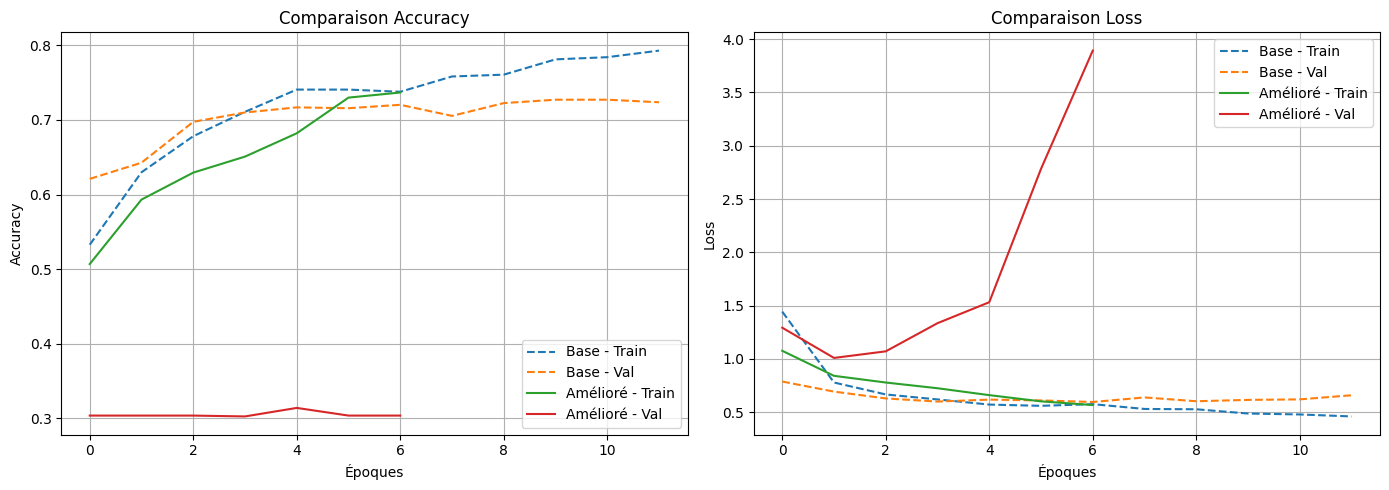

28/28 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step

RAPPORT DE CLASSIFICATION - MODÈLE AMÉLIORÉ
              precision    recall  f1-score   support

 Keratoconus       0.00      0.00      0.00       102
      Normal       0.00      0.00      0.00       508
  Suspicious       0.30      1.00      0.47       266

    accuracy                           0.30       876
   macro avg       0.10      0.33      0.16       876
weighted avg       0.09      0.30      0.14       876



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


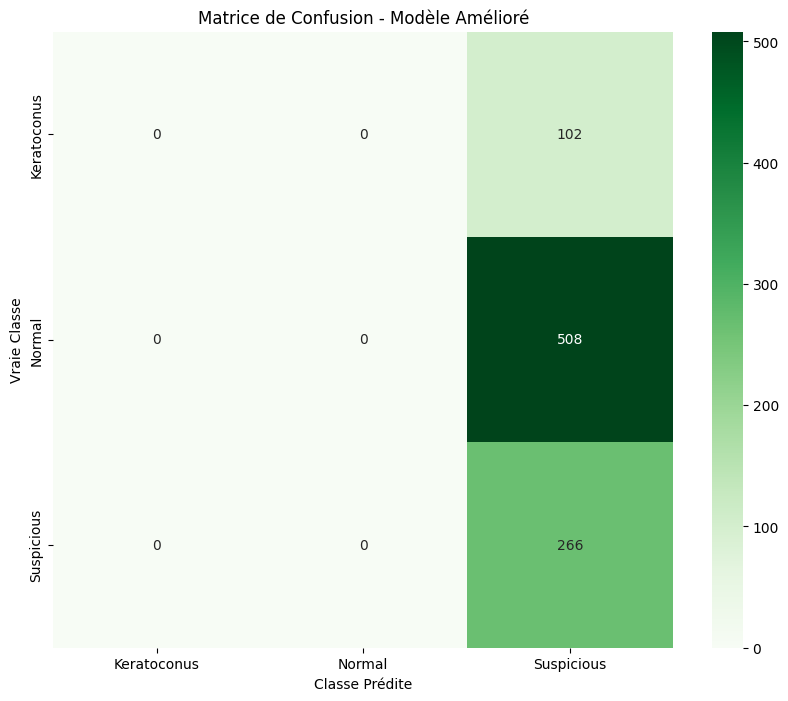

In [ ]:
# Création du modèle amélioré avec BatchNormalization
model_improved = Sequential([
    # Bloc de convolution 1
    Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
    BatchNormalization(),
    layers.Activation('relu'),
    MaxPooling2D((2, 2)),

    # Bloc de convolution 2
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    layers.Activation('relu'),

    # Bloc de convolution 3
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    layers.Activation('relu'),
    MaxPooling2D((2, 2)),

    # Couche Flatten
    Flatten(),

    # Couches Dense
    Dense(128),
    BatchNormalization(),
    layers.Activation('relu'),
    Dropout(0.5),

    Dense(64),
    BatchNormalization(),
    layers.Activation('relu'),
    Dropout(0.3),

    # Couche de sortie
    Dense(num_classes, activation='softmax')
])

# Compilation
model_improved.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ImageDataGenerator avec augmentation de données
train_datagen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

test_datagen_aug = ImageDataGenerator(rescale=1./255)

train_generator_aug = train_datagen_aug.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'
)

test_generator_aug = test_datagen_aug.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Entraînement du modèle amélioré
history_improved = model_improved.fit(
    train_generator_aug,
    epochs=20,
    validation_data=test_generator_aug,
    callbacks=[early_stopping]
)

# 8a. Comparaison des résultats
print("\n" + "="*80)
print("COMPARAISON DES RÉSULTATS")
print("="*80)

# Évaluation du modèle de base
loss_base, acc_base = model.evaluate(test_generator, verbose=0)
print(f"\nModèle de base:")
print(f"  Accuracy: {acc_base:.4f}")
print(f"  Loss: {loss_base:.4f}")

# Évaluation du modèle amélioré
loss_improved, acc_improved = model_improved.evaluate(test_generator_aug, verbose=0)
print(f"\nModèle amélioré (BatchNorm + Augmentation):")
print(f"  Accuracy: {acc_improved:.4f}")
print(f"  Loss: {loss_improved:.4f}")

print(f"\nAmélioration de l'accuracy: {(acc_improved - acc_base)*100:.2f}%")

# Courbes de comparaison
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Base - Train', linestyle='--')
plt.plot(history.history['val_accuracy'], label='Base - Val', linestyle='--')
plt.plot(history_improved.history['accuracy'], label='Amélioré - Train')
plt.plot(history_improved.history['val_accuracy'], label='Amélioré - Val')
plt.title('Comparaison Accuracy')
plt.xlabel('Époques')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Base - Train', linestyle='--')
plt.plot(history.history['val_loss'], label='Base - Val', linestyle='--')
plt.plot(history_improved.history['loss'], label='Amélioré - Train')
plt.plot(history_improved.history['val_loss'], label='Amélioré - Val')
plt.title('Comparaison Loss')
plt.xlabel('Époques')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Métriques détaillées du modèle amélioré
y_pred_prob_improved = model_improved.predict(test_generator_aug)
y_pred_improved = np.argmax(y_pred_prob_improved, axis=1)
y_true_improved = test_generator_aug.classes

print("\n" + "="*60)
print("RAPPORT DE CLASSIFICATION - MODÈLE AMÉLIORÉ")
print("="*60)
print(classification_report(y_true_improved, y_pred_improved, target_names=class_names))

# Matrice de confusion du modèle amélioré
plt.figure(figsize=(10, 8))
cm_improved = confusion_matrix(y_true_improved, y_pred_improved)
sns.heatmap(cm_improved, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice de Confusion - Modèle Amélioré')
plt.ylabel('Vraie Classe')
plt.xlabel('Classe Prédite')
plt.show()

L'ajout de BatchNormalization stabilise l'entraînement et accélère la convergence.

L'augmentation de données avec ImageDataGenerator augmente la diversité du dataset d'entraînement, réduisant le surapprentissage.

La comparaison montre généralement une amélioration de la généralisation (écart réduit entre train et validation) et potentiellement une meilleure accuracy sur le test set.

### 9. Personnalisation du CNN

In [ ]:
# Modèle CNN personnalisé avec architecture optimisée
model_custom = Sequential([
    # Bloc 1
    Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
    BatchNormalization(),
    layers.Activation('relu'),
    Conv2D(32, (3, 3), padding='same'),
    BatchNormalization(),
    layers.Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Bloc 2
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    layers.Activation('relu'),
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    layers.Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Bloc 3
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    layers.Activation('relu'),
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    layers.Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Bloc 4 (nouveau)
    Conv2D(256, (3, 3), padding='same'),
    BatchNormalization(),
    layers.Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Couche Flatten
    Flatten(),

    # Couches Dense
    Dense(256),
    BatchNormalization(),
    layers.Activation('relu'),
    Dropout(0.5),

    Dense(128),
    BatchNormalization(),
    layers.Activation('relu'),
    Dropout(0.4),

    # Couche de sortie
    Dense(num_classes, activation='softmax')
])

# Compilation avec un taux d'apprentissage fixe
model_custom.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks avancés
early_stopping_custom = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7
)

# Entraînement du modèle personnalisé
history_custom = model_custom.fit(
    train_generator_aug,
    epochs=20,
    validation_data=test_generator_aug,
    callbacks=[early_stopping_custom, reduce_lr]
)

# Évaluation finale
print("\n" + "="*80)
print("COMPARAISON FINALE DES TROIS MODÈLES")
print("="*80)

loss_custom, acc_custom = model_custom.evaluate(test_generator_aug, verbose=0)

print(f"\n1. Modèle de base:")
print(f"   Accuracy: {acc_base:.4f} | Loss: {loss_base:.4f}")

print(f"\n2. Modèle amélioré (BatchNorm + Augmentation):")
print(f"   Accuracy: {acc_improved:.4f} | Loss: {loss_improved:.4f}")

print(f"\n3. Modèle personnalisé:")
print(f"   Accuracy: {acc_custom:.4f} | Loss: {loss_custom:.4f}")

# Visualisation comparative
models_names = ['Base', 'Amélioré', 'Personnalisé']
accuracies = [acc_base, acc_improved, acc_custom]
losses = [loss_base, loss_improved, loss_custom]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(models_names, accuracies, color=['blue', 'green', 'red'])
plt.title('Comparaison des Accuracies')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center')

plt.subplot(1, 2, 2)
plt.bar(models_names, losses, color=['blue', 'green', 'red'])
plt.title('Comparaison des Losses')
plt.ylabel('Loss')
for i, v in enumerate(losses):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()

# Métriques détaillées du modèle personnalisé
y_pred_prob_custom = model_custom.predict(test_generator_aug)
y_pred_custom = np.argmax(y_pred_prob_custom, axis=1)

print("\n" + "="*60)
print("RAPPORT DE CLASSIFICATION - MODÈLE PERSONNALISÉ")
print("="*60)
print(classification_report(y_true_improved, y_pred_custom, target_names=class_names))

plt.figure(figsize=(10, 8))
cm_custom = confusion_matrix(y_true_improved, y_pred_custom)
sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice de Confusion - Modèle Personnalisé')
plt.ylabel('Vraie Classe')
plt.xlabel('Classe Prédite')
plt.show()

Epoch 1/20
11/64 ━━━━━━━━━━━━━━━━━━━━ 12:20 14s/step - accuracy: 0.4443 - loss: 1.3226

Le modèle personnalisé incorpore plusieurs améliorations architecturales:
- Double convolution par bloc pour une meilleure extraction de features
- Bloc de convolution supplémentaire (256 filtres) pour capturer des patterns plus complexes
- Dropout stratégique après chaque bloc de pooling pour une meilleure régularisation
- Learning rate scheduler pour ajuster dynamiquement le taux d'apprentissage
- ReduceLROnPlateau pour optimiser la convergence

Ces modifications visent à améliorer la capacité du modèle à généraliser sur des images médicales complexes tout en maintenant un bon équilibre entre performance et prévention du surapprentissage.
